In [1]:
import sys
sys.path.append('..')

# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d as td
from pepper import SimulationFdfd, PlaneWaveFdfd

[17:53:24] INFO     Using client version: 1.9.0                                                     ]8;id=214195;file:///home/lucas/micromamba/envs/mangoustan/lib/python3.9/site-packages/tidy3d/__init__.py\__init__.py]8;;\:]8;id=112015;file:///home/lucas/micromamba/envs/mangoustan/lib/python3.9/site-packages/tidy3d/__init__.py#115\115]8;;\

In [2]:
# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# # compute quantities based on geometry parameters
# x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
# y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
# wg_insert_x = ring_radius + wg_spacing
# wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.
# compute quantities based on geometry parameters
x_span = 2*wg_spacing + buffer
y_span = ring_radius + buffer
wg_insert_x = wg_spacing
wg_center_y = 0#ring_radius + couple_width + wg_width/2.

In [3]:
# wavelength range of interest
lambda_beg = 0.4
lambda_end = 0.6

# define pulse parameters
freq_beg = td.C_0 / lambda_end
freq_end = td.C_0 / lambda_beg
freq0 = (freq_beg + freq_end) / 2
fwidth = (freq_end - freq0) / 1.5

min_steps_per_wvl = 30
run_time = 1e-11

In [4]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)

In [5]:
# background of entire domain (set explicitly as a box)
background_box = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, td.inf],
    ),
    medium=background,
    name='background')

# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name='waveguide')

In [6]:
pw_fdfd = PlaneWaveFdfd(
    size=[td.inf,0,td.inf],
    center=(0, -y_span/4, 0),
    wavelength=1.55*1e-6,
    angle_theta=np.pi/4,
    angle_phi=0.0,
    direction='+',
)

bloch_x = td.Boundary.bloch_from_source(
    pw_fdfd,
    domain_size=x_span,
    axis=0)

sim_fdfd = SimulationFdfd(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.uniform(dl=x_span / 200),
    structures=[background_box, waveguide],
    # structures=[background_box],
    sources=[pw_fdfd],
    polarization='TE',
    #monitors=[field_monitor, mode_monitor],
    #run_time = 1,
    boundary_spec=td.BoundarySpec(x=bloch_x, y=td.Boundary.pml(), z=td.Boundary.periodic()),
)

In [7]:
sim_fdfd.grid_spec

GridSpec(grid_x=UniformGrid(type='UniformGrid', dl=0.03), grid_y=UniformGrid(type='UniformGrid', dl=0.03), grid_z=UniformGrid(type='UniformGrid', dl=0.03), wavelength=None, override_structures=(), type='GridSpec')

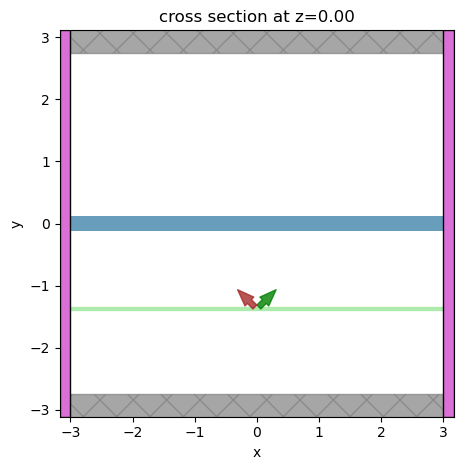

In [8]:
sim_fdfd.plot(z=0);

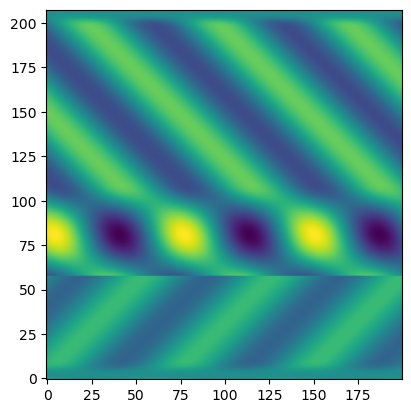

In [9]:
plt.imshow(np.real(sim_fdfd.run()).T, origin='lower');

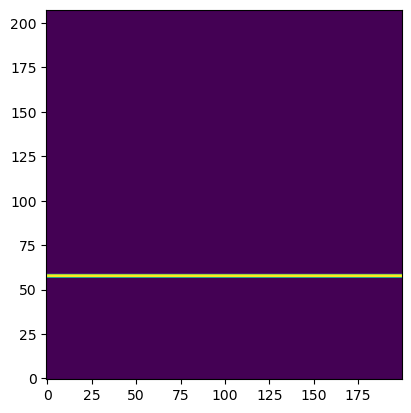

In [10]:
plt.imshow(np.abs(sim_fdfd.source[0].reshape(sim_fdfd.grid.num_cells).squeeze()).T, origin='lower')

In [11]:
pw_fdfd2 = PlaneWaveFdfd(
    size=[0, td.inf ,td.inf],
    center=(-x_span/4, 0, 0),
    wavelength=1.55*1e-6,
    angle_theta=0.3,
    angle_phi=0.0,
    direction='+',
)

bloch_y = td.Boundary.bloch_from_source(
    pw_fdfd2,
    domain_size=y_span,
    axis=1)

sim_fdfd2 = SimulationFdfd(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.uniform(dl=x_span / 200),
    # structures=[background_box, waveguide],
    structures=[background_box],
    sources=[pw_fdfd2],
    polarization='TE',
    #monitors=[field_monitor, mode_monitor],
    #run_time = 1,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=bloch_y, z=td.Boundary.periodic()),
)

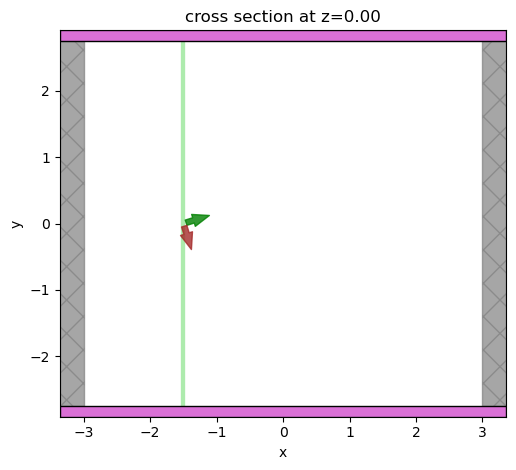

In [12]:
sim_fdfd2.plot(z=0);

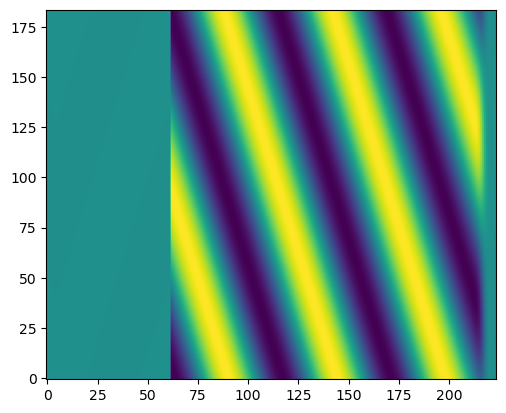

In [13]:
plt.imshow(np.real(sim_fdfd2.run()).T, origin='lower');

In [45]:
gauss = td.GaussianBeam(
    size=[0, 2 , 2],
    source_time=td.GaussianPulse(freq0=sim_fdfd.freq0, fwidth=0.1*sim_fdfd.freq0),
    center=(-x_span/4, 0, 0),
    angle_theta=0.3,
    angle_phi=0.0,
    direction='+',
)

bloch_y = td.Boundary.bloch_from_source(
    pw_fdfd2,
    domain_size=y_span,
    axis=1)

sim = td.Simulation(
    size=[x_span, y_span, 0],
    grid_spec=td.GridSpec.uniform(dl=x_span / 200),
    # structures=[background_box, waveguide],
    structures=[background_box],
    sources=[gauss],
    #monitors=[field_monitor, mode_monitor],
    run_time = 1,
    boundary_spec=td.BoundarySpec(x=td.Boundary.pml(), y=bloch_y, z=td.Boundary.periodic()),
)

<Axes: title={'center': 'cross section at z=0.00'}, xlabel='x', ylabel='y'>

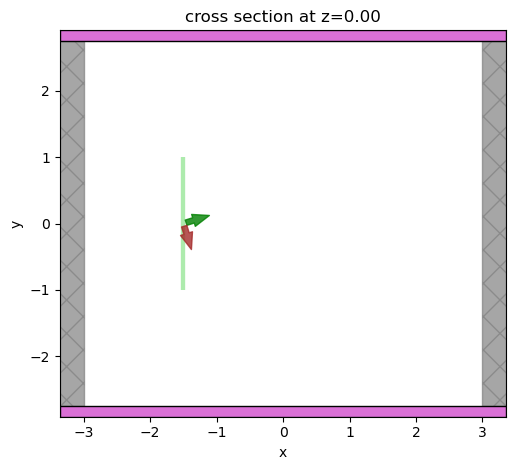

In [46]:
sim.plot(z=0)

In [47]:
gauss

GaussianBeam(type='GaussianBeam', center=(-1.5, 0.0, 0.0), size=(0.0, 2.0, 2.0), source_time=GaussianPulse(amplitude=1.0, phase=0.0, type='GaussianPulse', freq0=193414489116771.66, fwidth=19341448911677.168, offset=5.0), name=None, num_freqs=1, direction='+', angle_theta=0.3, angle_phi=0.0, pol_angle=0.0, waist_radius=1.0, waist_distance=0.0)

In [48]:
sim.discretize(gauss).boundaries.to_list

[array([-1.5 , -1.47]),
 array([-1.01630435, -0.98641304, -0.95652174, -0.92663043, -0.89673913,
        -0.86684783, -0.83695652, -0.80706522, -0.77717391, -0.74728261,
        -0.7173913 , -0.6875    , -0.6576087 , -0.62771739, -0.59782609,
        -0.56793478, -0.53804348, -0.50815217, -0.47826087, -0.44836957,
        -0.41847826, -0.38858696, -0.35869565, -0.32880435, -0.29891304,
        -0.26902174, -0.23913043, -0.20923913, -0.17934783, -0.14945652,
        -0.11956522, -0.08967391, -0.05978261, -0.0298913 ,  0.        ,
         0.0298913 ,  0.05978261,  0.08967391,  0.11956522,  0.14945652,
         0.17934783,  0.20923913,  0.23913043,  0.26902174,  0.29891304,
         0.32880435,  0.35869565,  0.38858696,  0.41847826,  0.44836957,
         0.47826087,  0.50815217,  0.53804348,  0.56793478,  0.59782609,
         0.62771739,  0.6576087 ,  0.6875    ,  0.7173913 ,  0.74728261,
         0.77717391,  0.80706522,  0.83695652,  0.86684783,  0.89673913,
         0.92663043,  0.956

In [49]:
gauss.pop_axis(, axis=gauss.injection_axis)

<function tidy3d.components.geometry.Geometry.pop_axis(coord: 'Tuple[Any, Any, Any]', axis: 'int') -> 'Tuple[Any, Tuple[Any, Any]]'>

In [51]:
sim.min_sym_box(gauss.center)

AttributeError: 'tuple' object has no attribute 'bounds'

In [54]:
type(gauss.size)

tuple

In [ ]:
gauss.unpop_axis(bounds_norm, bounds_plane, axis=gauss.normal_axis)